In [3]:
import torch
from torch import nn
from torch.optim import SGD
from avalanche.benchmarks.classic import SplitMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import LwFPlugin
from avalanche.training import Naive
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, timing_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin

# 1. 创建增量学习的基准数据集
# 这里以 SplitMNIST 为例子，它将 MNIST 数据集拆分为多个增量任务
benchmark = SplitMNIST(n_experiences=5, seed=1)

# 2. 定义模型
# 我们使用简单的 MLP（多层感知器）模型
model = SimpleMLP(num_classes=benchmark.n_classes)

# 3. 定义优化器
optimizer = SGD(model.parameters(), lr=0.01)

# 4. 定义损失函数
criterion = nn.CrossEntropyLoss()

# 5. 创建 LwF 插件
# alpha 是一个调节新旧任务损失平衡的系数，温度决定了知识蒸馏中的软化程度
lwf_plugin = LwFPlugin(alpha=0.5, temperature=2.0)

# 6. 定义评估插件，用于评估和记录实验结果
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True),
    timing_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)

# 7. 使用 Naive 训练策略并添加 LwF 插件
# Naive 策略是最基本的增量学习策略，不做特殊处理的情况下，直接训练新任务
strategy = Naive(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=32,
    train_epochs=4,
    eval_mb_size=100,
    plugins=[lwf_plugin],
    evaluator=eval_plugin,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# 8. 训练和评估模型
for experience in benchmark.train_stream:
    print("Training on experience ", experience.current_experience)
    strategy.train(experience)
    strategy.eval(benchmark.test_stream)


Training on experience  0
-- >> Start of training phase << --
100%|██████████| 355/355 [00:04<00:00, 84.62it/s] 
Epoch 0 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0233
100%|██████████| 355/355 [00:03<00:00, 96.77it/s] 
Epoch 1 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0022
100%|██████████| 355/355 [00:04<00:00, 83.94it/s]
Epoch 2 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0117
100%|██████████| 355/355 [00:03<00:00, 91.25it/s]
Epoch 3 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.1214
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 19/19 [00:00<00:00, 46.46it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.0494
	Time_Exp/eval_phase/test_stream/Task000/Exp000 = 0.4095
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.9849
-- Starting eval on experience 1 (Task 0) from test stream --
100

In [13]:
import os
import urllib.request
import zipfile
import torch
from torch import nn
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from avalanche.training.plugins import LwFPlugin
from avalanche.training import Naive
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, timing_metrics
from avalanche.logging import InteractiveLogger
from avalanche.training.plugins import EvaluationPlugin
import matplotlib.pyplot as plt

# 1. Download Tiny ImageNet dataset and extract it
def download_tiny_imagenet(data_dir):
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_file = os.path.join(data_dir, "tiny-imagenet-200.zip")

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if not os.path.exists(zip_file):
        print("Downloading Tiny ImageNet dataset...")
        urllib.request.urlretrieve(url, zip_file)

    extracted_dir = os.path.join(data_dir, "tiny-imagenet-200")
    if not os.path.exists(extracted_dir):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

    return extracted_dir

data_dir = "./data"
# tiny_imagenet_dir = download_tiny_imagenet(data_dir)
tiny_imagenet_dir = './data/tiny-imagenet-200'

# Organize validation set (if needed, we will move the images based on their annotations)
val_dir = os.path.join(tiny_imagenet_dir, 'val')
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')

# Create class subdirectories in the validation folder
def organize_val_images(val_dir, val_images_dir, val_annotations_file):
    if not os.path.exists(val_images_dir):
        return  # Already organized

    print("Organizing validation images into class folders...")
    with open(val_annotations_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            img_file, class_id = parts[0], parts[1]
            class_dir = os.path.join(val_dir, class_id)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            
            # Move images into corresponding class folder
            img_src_path = os.path.join(val_images_dir, img_file)
            img_dst_path = os.path.join(class_dir, img_file)
            if os.path.exists(img_src_path):
                os.rename(img_src_path, img_dst_path)

    # Remove the original images folder
    if os.path.exists(val_images_dir):
        os.rmdir(val_images_dir)

organize_val_images(val_dir, val_images_dir, val_annotations_file)

# 2. Define transformations and load Tiny ImageNet data using ImageFolder
transform = transforms.Compose([
    transforms.Resize(64),  # Tiny ImageNet images are 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train and validation datasets
train_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'train'), transform=transform)
val_dataset = ImageFolder(root=os.path.join(tiny_imagenet_dir, 'val'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

# 3. Load pre-trained ResNet18 and modify the final layer for 200 classes
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Change input channels to 1
num_classes = 200
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# 4. Define optimizer
optimizer = SGD(resnet18.parameters(), lr=0.01)

# 5. Define loss function
criterion = nn.CrossEntropyLoss()

# 6. Create LwF plugin
lwf_plugin = LwFPlugin(alpha=0.5, temperature=2.0)

# 7. Define evaluation plugin for logging metrics
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True),
    timing_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()]
)


Training epoch 0
-- >> Start of training phase << --
610it [00:46, 13.21it/s]                         
Epoch 0 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0506
100%|██████████| 355/355 [00:14<00:00, 24.32it/s]
Epoch 1 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0562
100%|██████████| 355/355 [00:12<00:00, 29.08it/s]
Epoch 2 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0539
100%|██████████| 355/355 [00:13<00:00, 26.85it/s]
Epoch 3 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.0715
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 397/397 [00:11<00:00, 33.31it/s]
Epoch 0 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.3825
100%|██████████| 397/397 [00:10<00:00, 38.04it/s]
Epoch 1 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.3591
100%|██████████| 397/397 [00:14<00:00, 27.78it/s]
Epoch 2 ended.
	Loss_MB/train_phase/train_stream/Task000 = 0.3943
100%|██████████| 397/397 [00:18<00:00, 21.65it/s]
Epoch 3 ended.


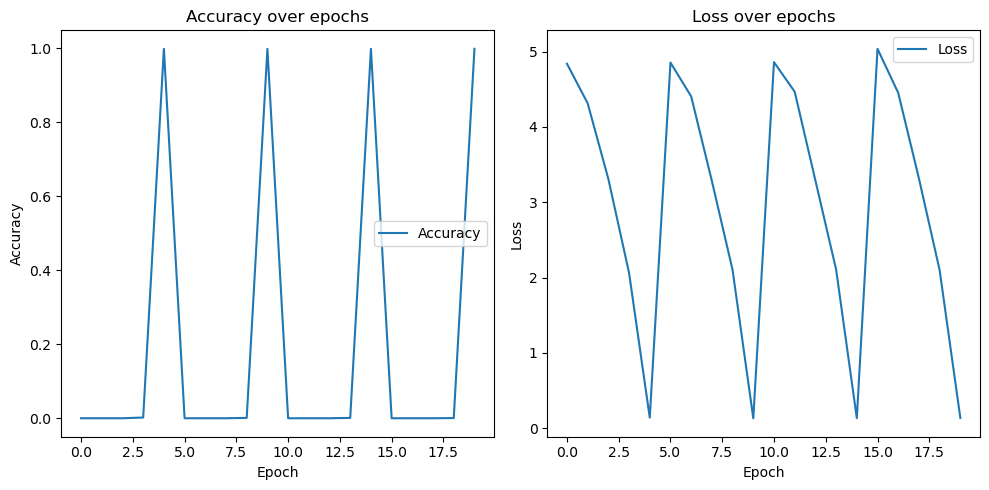

In [25]:
# 8. Define Naive strategy with LwF plugin
strategy = Naive(
    model=resnet18,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=32,
    train_epochs=4,
    eval_mb_size=100,
    plugins=[lwf_plugin],
    evaluator=eval_plugin,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Save training accuracy and loss history for plotting
accuracy_history = []
loss_history = []

# 9. Training and evaluation loop
# Use experiences from Avalanche's benchmark, such as from benchmark.train_stream
for epoch in range(4):  # 训练 4 个 epoch
    print(f"Training epoch {epoch}")
    
    # Iterate over experiences from the benchmark's training stream
    for experience in benchmark.train_stream:
        # Train on the current experience
        strategy.train(experience)
    
    # 在每个 epoch 后进行评估
    results = strategy.eval(benchmark.test_stream)
    # print('*************',results.keys())
    
    # Save accuracy and loss
    for key in results.keys():
        if 'Top1_Acc_Exp' in key:  # 寻找包含 Top1_Acc_Exp 的键
            accuracy_history.append(results[key])
            print(f"Added accuracy for {key}: {results[key]}")
        if 'Loss_Exp' in key:  # 寻找包含 Loss_Exp 的键
            loss_history.append(results[key])
            print(f"Added loss for {key}: {results[key]}")

# 10. Plot accuracy and loss over epochs
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracy_history, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.tight_layout()
plt.savefig('lwf_tiny_imagenet_naive.png')
plt.show()